# <center>Лабораторная работа №9
## <center>Анализ временных рядов
    
**Заполните пропущенный код.**

In [0]:
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

4.4.1


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [0]:
df = pd.read_csv('wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [0]:
df.shape

(383, 7)

In [0]:
df.date = pd.to_datetime(df.date)
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [0]:
from fbprophet import Prophet

In [0]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


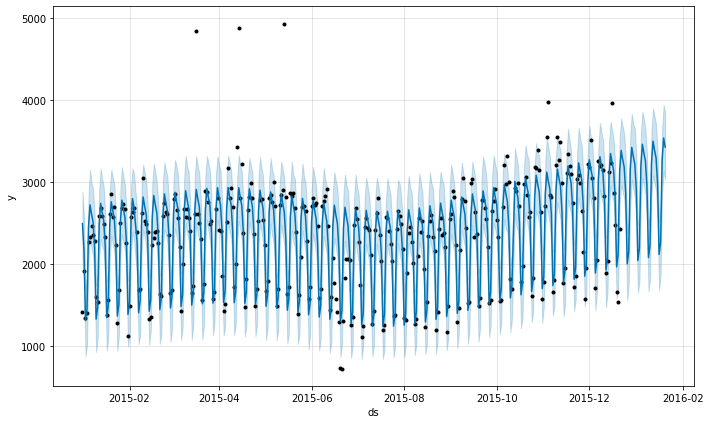

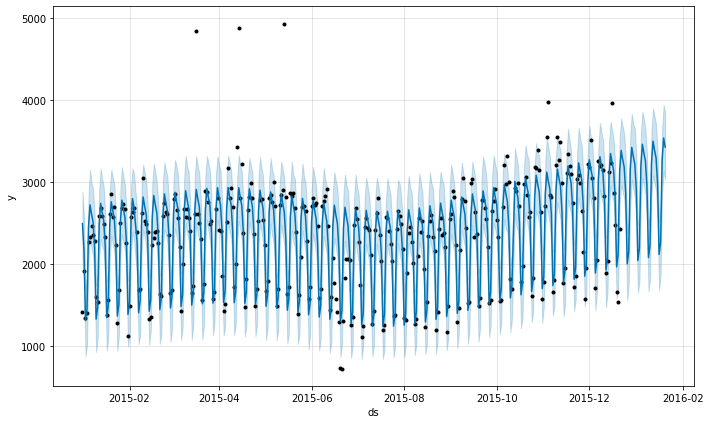

In [0]:
## ВАШ КОД для построения модели ##
m = Prophet()
m.fit(train_df)
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)
m.plot(forecast)

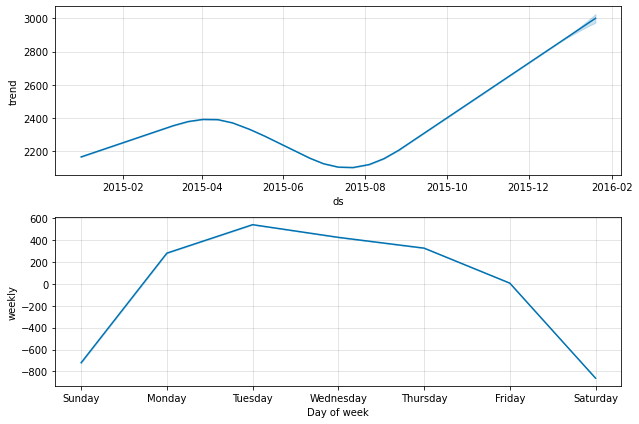

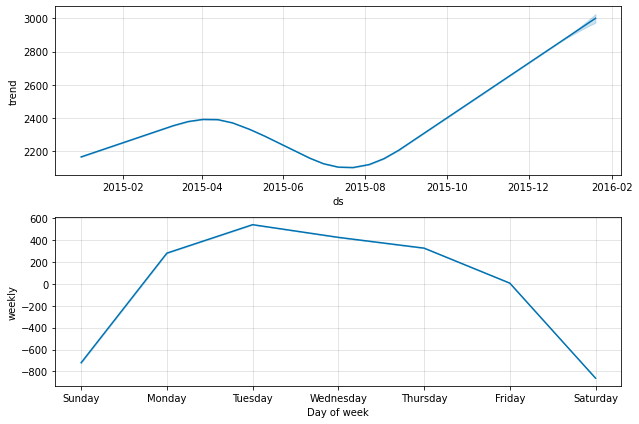

In [0]:
m.plot_components(forecast)


**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

In [0]:
## ВАШ КОД для оценки качества полученной модели ##
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))


In [0]:
cmp_df
#3426

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2015-01-01,2493.394569,2063.142158,2885.478383,1414
2015-01-02,2176.170858,1788.720427,2580.751165,1920
2015-01-03,1310.164121,875.898902,1694.994684,1338
2015-01-04,1453.891639,1009.540917,1840.903249,1404
2015-01-05,2458.694224,2068.197631,2859.554469,2264
...,...,...,...,...
2016-01-16,2117.626592,1675.671291,2511.828483,1644
2016-01-17,2264.022238,1864.508014,2700.041048,1836
2016-01-18,3271.492950,2869.501515,3645.545322,2983


In [0]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print ('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
print ('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE 34.502925740494526
MAE 599.8383194732162


In [0]:
def show_forecast(cmp_df, num_predictions, num_values):
    # верхняя граница доверительного интервала прогноза
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    # прогноз
    forecast = go.Scatter(
        name='Prediction',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    # нижняя граница доверительного интервала
    lower_bound = go.Scatter(
        name='Lower Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_lower,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines')

    # фактические значения
    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines')

    # последовательность рядов в данном случае важна из-за применения заливки
    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='Посты'),
        title='Просмотры на wiki',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, predictions, 100)

**Вопрос 2**: Какое получилось MAPE?

**Вопрос 3**: Какое получилось MAE?

## Предсказываем с помощью ARIMA

In [0]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 10
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (15, 10)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Dickey-Fuller test: p=0.107392


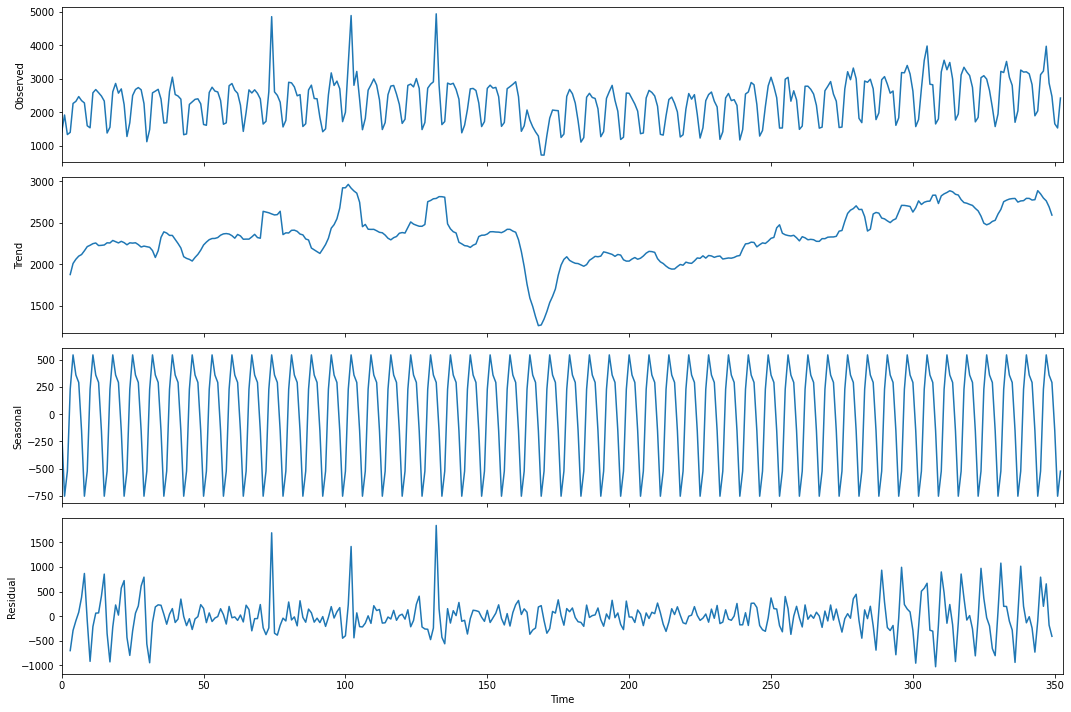

In [0]:
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])
#не стационарный

**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [0]:
## ВАШ КОД для построения модели ##
ps = range(0, 2)
ds = range(0, 2)
qs = range(0, 4)
Ps = range(0, 4)
Ds = range(0, 3)
Qs = range(0, 2)

from itertools import product

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)





384

In [0]:
%%time
import warnings
from tqdm import tqdm
results1 = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

100%|██████████| 384/384 [17:41<00:00,  2.76s/it]

CPU times: user 20min 15s, sys: 14min 39s, total: 34min 54s
Wall time: 17min 41s


In [0]:
result_table1 = pd.DataFrame(results1)
result_table1.columns = ['parameters', 'aic']
print(result_table1.sort_values(by = 'aic', ascending=True).head())

             parameters          aic
165  (0, 1, 2, 3, 2, 1)  4961.632628
332  (1, 1, 1, 3, 2, 1)  4962.858934
380  (1, 1, 3, 3, 2, 1)  4965.648758
189  (0, 1, 3, 3, 2, 1)  4969.534606
213  (1, 0, 0, 3, 2, 1)  4973.212242


In [0]:
import scipy.stats
train_df['y_box'], lmbda = scipy.stats.boxcox(train_df['y']) 
print("The optimal Box-Cox transformation parameter: %f" % lmbda)

The optimal Box-Cox transformation parameter: 0.732841


In [0]:
results2 = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y_box'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results2.append([param, model.aic])
    
warnings.filterwarnings('default')

100%|██████████| 384/384 [14:17<00:00,  2.23s/it]


In [0]:
result_table2 = pd.DataFrame(results2)
result_table2.columns = ['parameters', 'aic']
print(result_table2.sort_values(by = 'aic', ascending=True).head())

             parameters          aic
256  (1, 0, 2, 3, 2, 1)  3528.650849
210  (1, 0, 0, 3, 2, 1)  3530.524249
375  (1, 1, 3, 3, 2, 1)  3531.814858
233  (1, 0, 1, 3, 2, 1)  3532.092279
328  (1, 1, 1, 3, 2, 1)  3534.434779


In [0]:
result_table2[result_table2['parameters'].isin([(1, 0, 2, 3, 1, 0),
                                                (1, 1, 2, 3, 2, 1),
                                                (1, 1, 2, 3, 1, 1),
                                                (1, 0, 2, 3, 0, 0)])].sort_values(by='aic')

,parameters,aic
351,"(1, 1, 2, 3, 2, 1)",3534.540192
253,"(1, 0, 2, 3, 1, 0)",3556.880030
350,"(1, 1, 2, 3, 1, 1)",3557.850934
251,"(1, 0, 2, 3, 0, 0)",3674.916024


In [0]:
D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1  
#лучшие параметры